In [1]:
# !pip install -r requirements.txt

In [2]:
%matplotlib nbagg
from fastmri_recon.data.utils.masking.gen_mask_tf import gen_mask_tf
from fastmri_recon.models.utils.fourier import tf_unmasked_op as tf_fft
from fastmri_recon.models.utils.fourier import tf_unmasked_adj_op as tf_ifft
from fastmri_recon.models.utils.fourier import tf_op as tf_masked_fft
from fastmri_recon.models.utils.fourier import tf_adj_op as tf_masked_ifft
from fastmri_recon.models.utils.masking import _mask_tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD

In [3]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In MRI, data is acquired in the k-space. This k-space $y$ is (in an ideal version) the fourier transform $F$ of the anatomical image $x$: $y = Fx$.

However, because each point (rather each trajectory) in the k-space takes time to acquire, we are going to subsample the fourier coefficients according to a given pattern $\Omega$: $y = F_{\Omega}x$.

This is an ill-posed inverse problem.

<IPython.core.display.Javascript object>


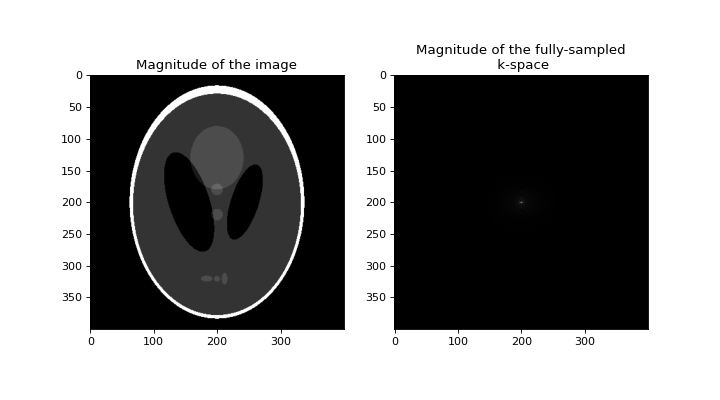

Text(0.5, 1.0, 'Magnitude of the fully-sampled\n k-space')

In [4]:
# let's load our data and see what it looks like
image = np.load('shepp_logan.npy')
# we add a batch and a channel dimension because the ops need it tow work correctly
# indeed in tf, the images are usually in the shape NHWC
# we also need it in complex dtype
image = image.astype(np.complex64)[None, ..., None]
image = tf.convert_to_tensor(image)
kspace = tf_fft(image)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(tf.abs(image)))
axs[0].set_title('Magnitude of the image')
axs[1].imshow(np.squeeze(tf.abs(kspace)))
axs[1].set_title('Magnitude of the fully-sampled\n k-space')

A naive solution is to take the inverse fourier transform of the sampled coefficients, with non-sampled coefficients filled to 0. The solution is then called the zero-filled solution.

<IPython.core.display.Javascript object>


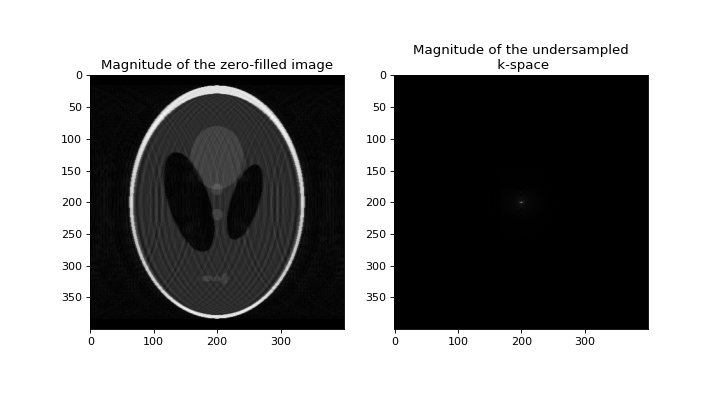

Text(0.5, 1.0, 'Magnitude of the undersampled\n k-space')

In [5]:
# we are going to accelerate the MRI acquisition by a factor 2
mask = gen_mask_tf(kspace[..., 0], accel_factor=2)
masked_kspace = _mask_tf([kspace, mask])
zero_filled_image = tf_ifft(masked_kspace)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(tf.abs(zero_filled_image)))
axs[0].set_title('Magnitude of the zero-filled image')
axs[1].imshow(np.squeeze(tf.abs(masked_kspace)))
axs[1].set_title('Magnitude of the undersampled\n k-space')

As you can see, the image is strongly aliased. We need a better solution.

For that, we will need to solve an optimisation problem with a data-consistency term and a regularisation term:
$$
argmin_{x \in \mathbb{C}^n} \frac12 \|F_{\Omega} x - y\|_2^2 + \lambda \|x\|_{TV} 
$$

We rewrite this problem in the saddle point problem, with $D$ the total variation operator:
$$
argmin_{x \in \mathbb{C}^n} max_{z\in \mathbb{C}, \|z\|_1 \leq \lambda} \frac12 \|F_{\Omega} x - y\|_2^2 + \lambda <z; Dx>
$$

In [34]:
# let's write that in tf
x = tf.Variable(zero_filled_image, trainable=True, name='primal')
lamb = tf.constant(1.0)

paddings1 = tf.constant([[0, 0,], [1, 0], [0, 0,], [0, 0,]])
paddings2 = tf.constant([[0, 0,], [0, 0], [1, 0,], [0, 0,]])
def d_tv(_x):
    # they need 0 padding
    pixel_dif1 = _x[:, 1:, :, :] - _x[:, :-1, :, :]
    pixel_dif1 = tf.pad(pixel_dif1, paddings1)
    pixel_dif2 = _x[:, :, 1:, :] - _x[:, :, :-1, :]
    pixel_dif2 = tf.pad(pixel_dif2, paddings2)
    return tf.concat([pixel_dif1, pixel_dif2], axis=-1)

def dual_constraint(_z):
    l1_norm = tf.reduce_sum(tf.abs(_z))
    l1_norm = tf.cast(l1_norm, _z.dtype)
    projected_z = _z / l1_norm
    return projected_z

z = tf.Variable(
    tf.zeros_like(d_tv(zero_filled_image), dtype=tf.complex64), 
    trainable=True, 
    name='dual',
    constraint=dual_constraint,
)

def original_loss(_x):
    return tf.nn.l2_loss(tf.abs(tf_masked_fft([_x, mask]) - kspace)) + tf.image.total_variation(_x)


def return_loss_primal():
    data_fidelity = tf.nn.l2_loss(tf.abs(tf_masked_fft([x, mask]) - kspace))
    # because we have complex variables we need to handle the scalar product correctly
    regularisation_real = tf.multiply(tf.math.real(d_tv(x)), tf.math.real(tf.math.conj(z)))
    regularisation_imag = tf.multiply(tf.math.imag(d_tv(x)), tf.math.imag(tf.math.conj(z)))
    regularisation = tf.reduce_sum(regularisation_real + regularisation_imag)
    loss = data_fidelity + lamb * regularisation
    return loss

def return_loss_dual():
    return - return_loss_primal()

return_loss_primal()

<tf.Tensor: shape=(), dtype=float32, numpy=219.06424>

In [35]:
original_loss(image)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2716.3818], dtype=float32)>

In [36]:
optimizer_primal = SGD(learning_rate=1e-1)
optimizer_dual = SGD(learning_rate=1e-1)
n_iter = 10
for i_iter in range(n_iter):
    optimizer_primal.minimize(return_loss_primal, [x])
    optimizer_dual.minimize(return_loss_dual, [z])
    print(i_iter, original_loss(x))

0 tf.Tensor([11013.289], shape=(1,), dtype=float32)
1 tf.Tensor([11012.985], shape=(1,), dtype=float32)
2 tf.Tensor([11012.713], shape=(1,), dtype=float32)
3 tf.Tensor([11012.467], shape=(1,), dtype=float32)
4 tf.Tensor([11012.248], shape=(1,), dtype=float32)
5 tf.Tensor([11012.049], shape=(1,), dtype=float32)
6 tf.Tensor([11011.871], shape=(1,), dtype=float32)
7 tf.Tensor([11011.712], shape=(1,), dtype=float32)
8 tf.Tensor([11011.568], shape=(1,), dtype=float32)
9 tf.Tensor([11011.439], shape=(1,), dtype=float32)


<IPython.core.display.Javascript object>


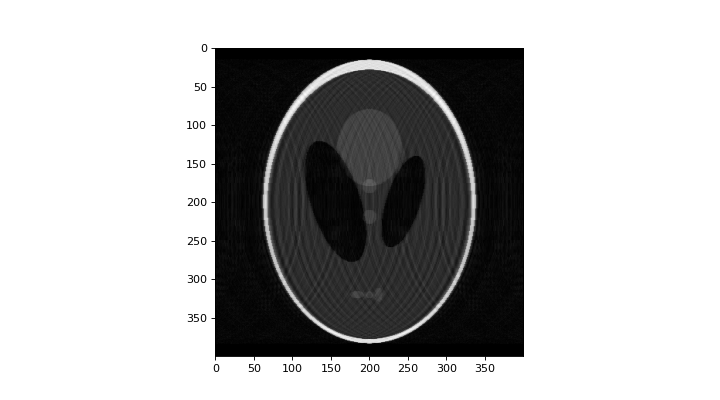

In [37]:
plt.figure()
plt.imshow(np.squeeze(np.abs(x)))